# Create data frames

In [1]:
import pyNUISANCE as pn
import numpy as np
import pyProSelecta as pps
import pyNuHepMC as nhm
import matplotlib.pyplot as plt
import scipy

In [2]:
evs = pn.EventSource("DUNEND_FHC_numu_Ar40_GENIEv3_G18_10a_00_000_11M_NUISFLAT.pb.gz")
if not evs:
    print("Error: failed to open input file")

In [3]:
pps.load_text("""

double dot(HepMC3::FourVector const &a, HepMC3::FourVector const &b){
    return a.x()*b.x() + a.y()*b.y() + a.z()*b.z();
}

double delta_theta_deg(HepMC3::FourVector const &a, HepMC3::FourVector const &b){
    constexpr double deg2rad = 180.0/M_PI;
    return std::acos(dot(a,b)/(a.length()*b.length())) * deg2rad;
}

std::vector<double> enuptpzthlepeav_GeV(HepMC3::GenEvent const &ev){
  auto bpart = ps::sel::Beam(ev,14);
  if(!bpart) {
      return {};
  }

  auto cclep = ps::sel::PrimaryCCLepForNu(ev,bpart);
  if(!cclep){
    return {bpart->momentum().e() * 1E-3};
  }

  // Get total energy of hadronic system.
  double Erecoil = 0;

  for (auto part : ps::sel::OutPartsAny(ev, {})) {
    auto pid = part->pid();

    // Skip CC Lepton and neutrons
    if ((part->id() == cclep->id()) || (pid == 2112) ){
      continue;
    }

    // KE of Protons and charged pions
    if ((pid == 2212) || (pid == 211) || (pid == -211)) {
      Erecoil += (part->momentum().e() - part->momentum().m());
    } else if ((pid == 111) || (std::abs(pid) == 11) || (pid == 22)) {
      Erecoil += part->momentum().e();
    }
  }

  constexpr double deg2rad = 180.0/M_PI;
  return {bpart->momentum().e() * 1E-3, 
      cclep->momentum().z() * 1E-3, cclep->momentum().perp() * 1E-3, 
      delta_theta_deg(cclep->momentum(), bpart->momentum()), 
      Erecoil * 1E-3, (cclep->momentum().e() + Erecoil) * 1E-3};
}

int isMINERvALowRecoil(HepMC3::GenEvent const &ev){
  auto bpart = ps::sel::Beam(ev,14);
  if(!bpart) {
      return 0;
  }

  auto cclep = ps::sel::PrimaryCCLepForNu(ev,bpart);
  if(!cclep){
    return 0;
  }

  if(cclep->momentum().e() < 1500){
    return 0;
  }

  
  if(delta_theta_deg(cclep->momentum(), bpart->momentum()) > 20.0){
    return 0;
  }
  
  return 1;
}

int sample_topo(HepMC3::GenEvent const &ev){
  auto bpart = ps::sel::Beam(ev,14);
  if(!bpart) {
      return 0;
  }

  auto cclep = ps::sel::PrimaryCCLepForNu(ev,bpart);
  if(!cclep){
    return 1;
  }

  auto nparts = ps::sel::OutPartsAny(ev,{}).size();
  auto weird_stuff = ps::sel::OutPartsExceptAny(ev, {13,2112,2212,111,211,-211,22});
  auto nleps = ps::sel::OutPartsAny(ev,{13,-13}).size();
  auto npi0 = ps::sel::OutParts(ev,111).size();
  auto ncpi = ps::sel::OutPartsAny(ev,{211,-211}).size();
  auto gammas = ps::sel::OutParts(ev,22);

  for(auto &p : weird_stuff){
    if((p->pid() < 1000000000)){
      return 2; // other
    }
  }

  for(auto &p : gammas){
    if(p->momentum().e() > 25){
      return 2;//other
    }
  }

  if((nleps != 1) || (npi0 != 0) || (ncpi > 1)){
    return 2; //other
  }
  if(ncpi == 1){
    return 3; // 1cpi
  }
  return 4; //0pi
}

int sample_mode(HepMC3::GenEvent const &ev){
  auto procid = NuHepMC::ER3::ReadProcessID(ev);

  auto bpart = ps::sel::Beam(ev,14);
  if(!bpart) {
      return 0;
  }

  auto cclep = ps::sel::PrimaryCCLepForNu(ev,bpart);
  if(!cclep){
    return 1;
  }

  if( (200 <= procid) && (procid < 300) ){ //qe
    return 2;
  } else if( (300 <= procid) && (procid < 400) ){ //2p2h
    return 3;
  } else if ( (400 <= procid) && (procid < 500) ){ //res
    return 4;
  } else if ( (500 <= procid) && (procid < 700) ){ //sis+dis
    return 5;
  }
  return 6;
}

""")

True

In [4]:
import pyarrow as pa
import os

In [5]:
remake_table = False
if not os.path.isfile('minervalike.arrow') or remake_table:
    fg = pn.EventFrameGen(evs)
    fg.filter(pps.select.get("isMINERvALowRecoil"))
    fg.add_uint16_column("channel_id", pps.select.get("sample_mode"))
    fg.add_uint16_column("topology_id", pps.select.get("sample_topo"))
    fg.add_float_columns(["Enu_GeV", "lep_pz_GeV", "lep_pt_GeV", "lep_theta_deg", "EAvHad_GeV", "ERec_GeV"],
                          pps.project.get_vect("enuptpzthlepeav_GeV"))

    wnf5_disp = pn.Prob3plusplusWeightCalc()
    wnf5_disp.set_parameters({"baseline_km": 1300, "NuFit:5.2": 1, "osc:numu_disp":1})

    fg.add_float_column("prob_disp", wnf5_disp.calc_weight)

    chunk = fg.firstArrow()
    with pa.OSFile('minervalike.arrow', 'wb') as sink:
        with pa.ipc.new_file(sink, chunk.schema) as writer:
            while chunk:
                writer.write_batch(chunk)
                chunk = fg.nextArrow()

with pa.memory_map('minervalike.arrow', 'rb') as source:
    table = pa.ipc.open_file(source).read_all()

In [6]:
print(table.to_pandas())

         event.number  weight.cv  process.id  fatx.estimate  channel_id  \
0                   0        1.0         600   1.365882e-37           5   
1                   4        1.0         600   1.365882e-37           5   
2                  10        1.0         402   1.365882e-37           4   
3                  11        1.0         402   1.365882e-37           4   
4                  12        1.0         200   1.365882e-37           2   
...               ...        ...         ...            ...         ...   
2401609      10999983        1.0         402   1.365882e-37           4   
2401610      10999986        1.0         500   1.365882e-37           5   
2401611      10999989        1.0         300   1.365882e-37           3   
2401612      10999996        1.0         600   1.365882e-37           5   
2401613      10999998        1.0         600   1.365882e-37           5   

         topology_id    Enu_GeV  lep_pz_GeV  lep_pt_GeV  lep_theta_deg  \
0                  2  21.

# Make the Histograms

In [7]:
enubins = pn.Binning.lin_space(1.5,10,50)
ptbins = pn.Binning.lin_space(0,1.25,5)
pzbins = pn.Binning.lin_space(1.5,10,50)
eavailbins = pn.Binning.lin_space(0,2,100)
erecbins = pn.Binning.lin_space(0,10,100)

In [8]:
import copy

def add_mode_cols(h):
    h.add_column("NC")
    h.add_column("QE")
    h.add_column("2p2h")
    h.add_column("RES")
    h.add_column("SIS+DIS")
    h.add_column("Other")

def add_topo_cols(h):
    h.add_column("NC")
    h.add_column("other")
    h.add_column("1cpi")
    h.add_column("0pi")
    
enuhist = pn.HistFrame(enubins)
add_mode_cols(enuhist)
pthist = pn.HistFrame(ptbins)
add_mode_cols(pthist)
pzhist = pn.HistFrame(pzbins)
add_mode_cols(pzhist)
eavailhist = pn.HistFrame(eavailbins)
add_mode_cols(eavailhist)
erechist = pn.HistFrame(erecbins)
add_mode_cols(erechist)

enuhist_osc = copy.copy(enuhist)
pthist_osc = copy.copy(pthist)
pzhist_osc = copy.copy(pzhist)
eavailhist_osc = copy.copy(eavailhist)
erechist_osc = copy.copy(erechist)

enuhist.fill_columns_from_Arrow(table, ["Enu_GeV"], "channel_id")
pthist.fill_columns_from_Arrow(table, ["lep_pt_GeV"], "channel_id")
pzhist.fill_columns_from_Arrow(table, ["lep_pz_GeV"], "channel_id")
eavailhist.fill_columns_from_Arrow(table, ["EAvHad_GeV"], "channel_id")
erechist.fill_columns_from_Arrow(table, ["ERec_GeV"], "channel_id")

enuhist_osc.fill_columns_from_Arrow(table, ["Enu_GeV"], "channel_id",["weight.cv","prob_disp"])
pthist_osc.fill_columns_from_Arrow(table, ["lep_pt_GeV"], "channel_id",["weight.cv","prob_disp"])
pzhist_osc.fill_columns_from_Arrow(table, ["lep_pz_GeV"], "channel_id",["weight.cv","prob_disp"])
eavailhist_osc.fill_columns_from_Arrow(table, ["EAvHad_GeV"], "channel_id",["weight.cv","prob_disp"])
erechist_osc.fill_columns_from_Arrow(table, ["ERec_GeV"], "channel_id",["weight.cv","prob_disp"])

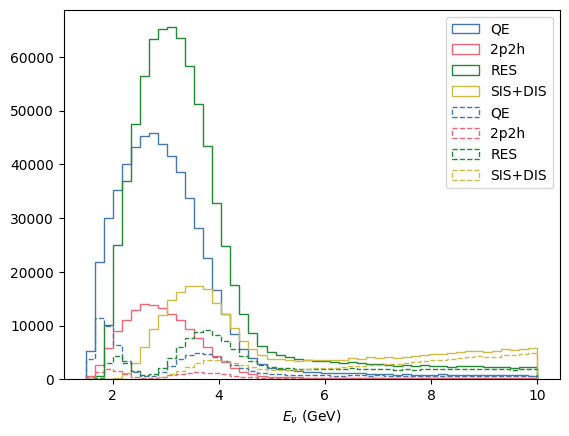

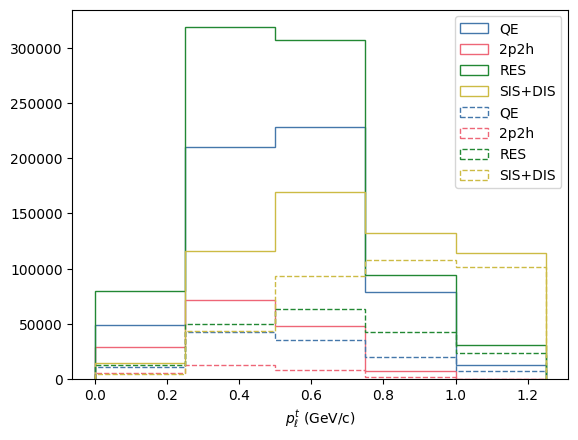

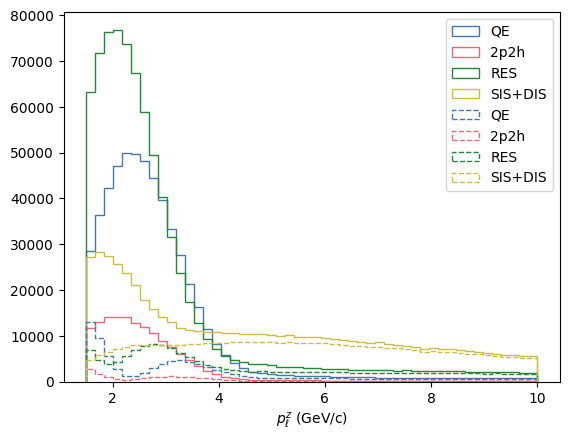

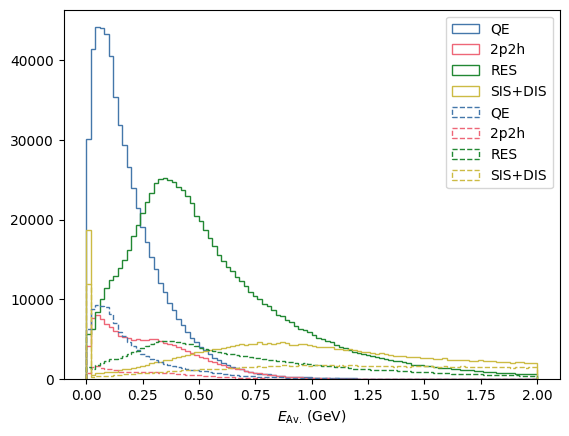

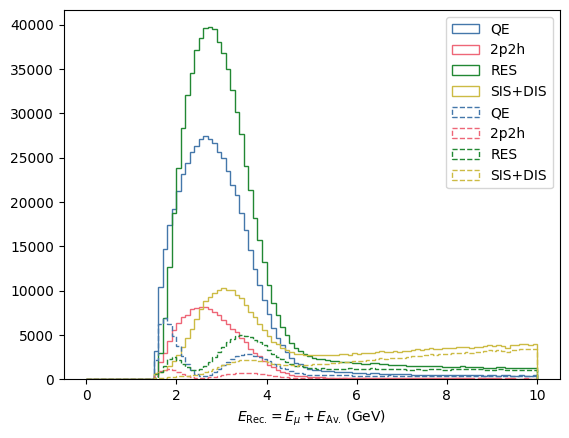

In [9]:
col_cycle = [ '#4477AA', '#EE6677', '#228833', '#CCBB44', '#66CCEE', '#AA3377', '#BBBBBB' ]
enuhist.mpl().hist_all(columns=["QE","2p2h","RES","SIS+DIS"],colors=col_cycle,histtype="step")
enuhist_osc.mpl().hist_all(columns=["QE","2p2h","RES","SIS+DIS"],colors=col_cycle,histtype="step",linestyle="dashed")
plt.xlabel(r"$E_{\nu}$ (GeV)")
plt.legend()
plt.show()

pthist.mpl().hist_all(columns=["QE","2p2h","RES","SIS+DIS"],colors=col_cycle,histtype="step")
pthist_osc.mpl().hist_all(columns=["QE","2p2h","RES","SIS+DIS"],colors=col_cycle,histtype="step",linestyle="dashed")
plt.xlabel(r"$p_{\ell}^{t}$ (GeV/c)")
plt.legend()
plt.show()

pzhist.mpl().hist_all(columns=["QE","2p2h","RES","SIS+DIS"],colors=col_cycle,histtype="step")
pzhist_osc.mpl().hist_all(columns=["QE","2p2h","RES","SIS+DIS"],colors=col_cycle,histtype="step",linestyle="dashed")
plt.xlabel(r"$p_{\ell}^{z}$ (GeV/c)")
plt.legend()
plt.show()

eavailhist.mpl().hist_all(columns=["QE","2p2h","RES","SIS+DIS"],colors=col_cycle,histtype="step")
eavailhist_osc.mpl().hist_all(columns=["QE","2p2h","RES","SIS+DIS"],colors=col_cycle,histtype="step",linestyle="dashed")
plt.xlabel(r"$E_\text{Av.}$ (GeV)")
plt.legend()
plt.show()

erechist.mpl().hist_all(columns=["QE","2p2h","RES","SIS+DIS"],colors=col_cycle,histtype="step")
erechist_osc.mpl().hist_all(columns=["QE","2p2h","RES","SIS+DIS"],colors=col_cycle,histtype="step",linestyle="dashed")
plt.xlabel(r"$E_\text{Rec.} = E_\mu + E_\text{Av.}$ (GeV)")
plt.legend()
plt.show()

In [10]:
pzpteav_hist = pn.HistFrame(pn.Binning.product([ptbins,pzbins,eavailbins]))
add_mode_cols(pzpteav_hist)

pzpteav_hist_osc = copy.copy(pzpteav_hist)

pzpteav_hist.fill_columns_from_Arrow(table, ["lep_pt_GeV","lep_pz_GeV","EAvHad_GeV"], 
                                     "channel_id")
pzpteav_hist_osc.fill_columns_from_Arrow(table, ["lep_pt_GeV","lep_pz_GeV","EAvHad_GeV"], 
                                         "channel_id",["weight.cv","prob_disp"])

/tmp/ipykernel_40078/1810717154.py:10: RuntimeWarning: invalid value encountered in divide
  pteav_rat.sumweights = np.divide(pteav_osc.sumweights,pteav.sumweights)


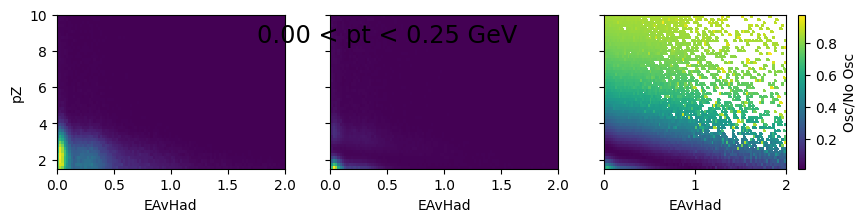

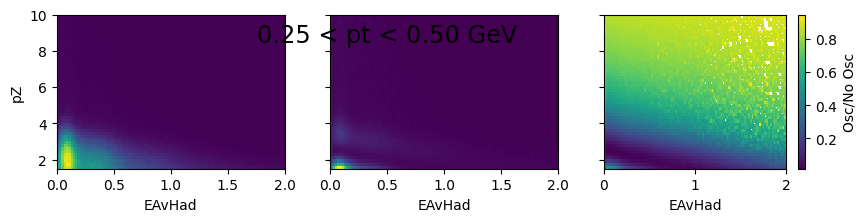

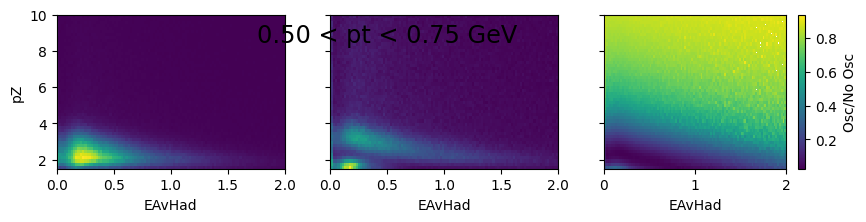

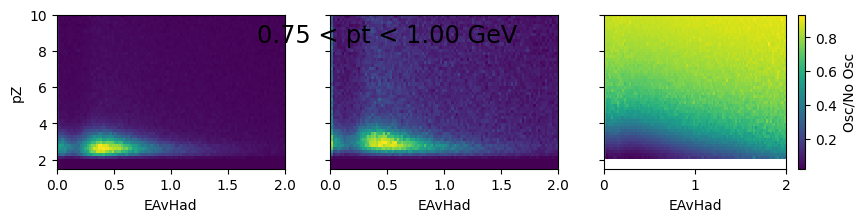

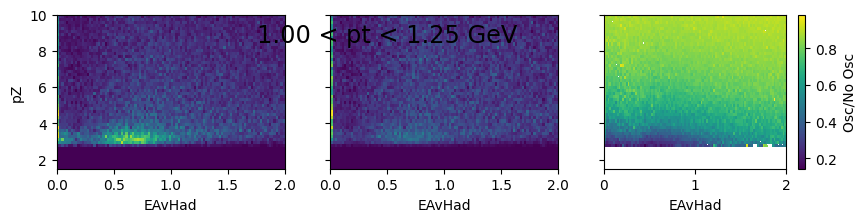

In [11]:
for ptb in ptbins.bins:
    bc = (ptb[0].low + ptb[0].high)/2.0
    pteav = pzpteav_hist.slice(0,bc).project([1,0])
    pteav_osc = pzpteav_hist_osc.slice(0,bc).project([1,0])
    
    fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(10,2),sharey=True)
    pteav.mpl().colormesh(plot_axis=ax1)
    pteav_osc.mpl().colormesh(plot_axis=ax2)
    pteav_rat = copy.copy(pteav_osc)
    pteav_rat.sumweights = np.divide(pteav_osc.sumweights,pteav.sumweights)
    rat_pcm = pteav_rat.mpl().colormesh(plot_axis=ax3)

    ax2.text(0.5, 8.5,"%.2f < pt < %.2f GeV" % (ptb[0].low,ptb[0].high), clip_on=False, 
             horizontalalignment="center", fontsize="xx-large")

    ax1.set_ylabel("pZ")
    ax1.set_xlabel("EAvHad")
    ax2.set_xlabel("EAvHad")
    ax3.set_xlabel("EAvHad")
    fig.colorbar(rat_pcm,label="Osc/No Osc")
    fig.show()
    # break


In [12]:
pzpterec_hist = pn.HistFrame(pn.Binning.product([ptbins,pzbins,erecbins]))
add_topo_cols(pzpterec_hist)

pzpterec_hist_osc = copy.copy(pzpterec_hist)

pzpterec_hist.fill_columns_from_Arrow(table, ["lep_pt_GeV","lep_pz_GeV","ERec_GeV"], 
                                     "topology_id")
pzpterec_hist_osc.fill_columns_from_Arrow(table, ["lep_pt_GeV","lep_pz_GeV","ERec_GeV"], 
                                         "topology_id",["weight.cv","prob_disp"])

/tmp/ipykernel_40078/3137986925.py:10: RuntimeWarning: invalid value encountered in divide
  pterec_rat.sumweights = np.divide(pterec_osc.sumweights,pterec.sumweights)


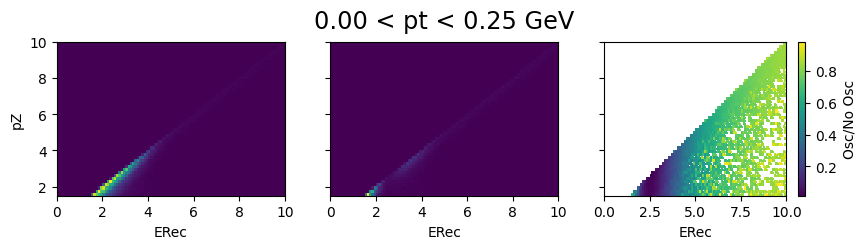

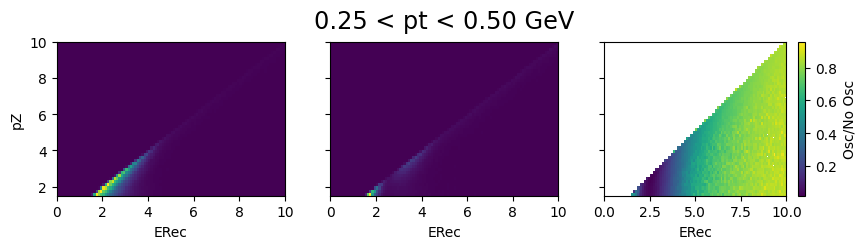

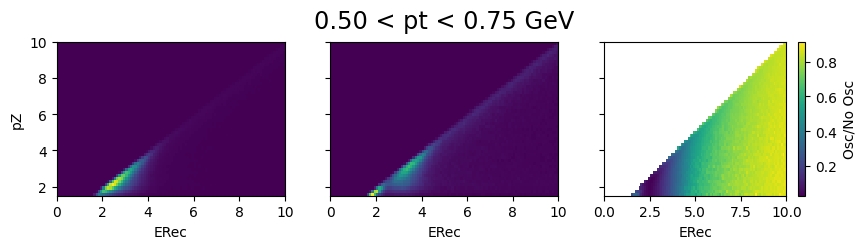

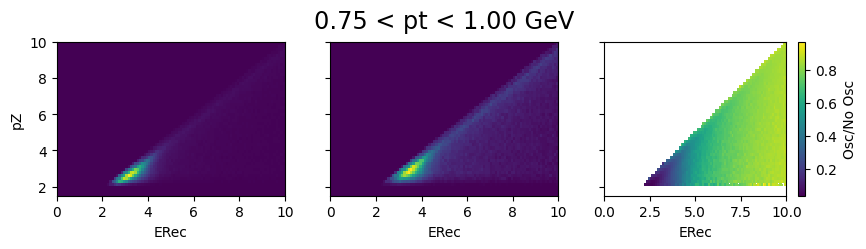

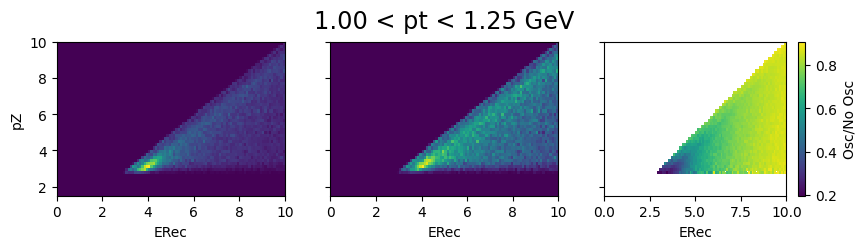

In [13]:
for ptb in ptbins.bins:
    bc = (ptb[0].low + ptb[0].high)/2.0
    pterec = pzpterec_hist.slice(0,bc).project([1,0])
    pterec_osc = pzpterec_hist_osc.slice(0,bc).project([1,0])
    
    fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(10,2),sharey=True)
    pterec.mpl().colormesh(plot_axis=ax1)
    pterec_osc.mpl().colormesh(plot_axis=ax2)
    pterec_rat = copy.copy(pterec_osc)
    pterec_rat.sumweights = np.divide(pterec_osc.sumweights,pterec.sumweights)
    rat_pcm = pterec_rat.mpl().colormesh(plot_axis=ax3)

    ax2.text(5, 10.75,"%.2f < pt < %.2f GeV" % (ptb[0].low,ptb[0].high), clip_on=False, 
             horizontalalignment="center", fontsize="xx-large")

    ax1.set_ylabel("pZ")
    ax1.set_xlabel("ERec")
    ax2.set_xlabel("ERec")
    ax3.set_xlabel("ERec")
    fig.colorbar(rat_pcm,label="Osc/No Osc")
    fig.show()

/tmp/ipykernel_40078/2490015477.py:9: RuntimeWarning: invalid value encountered in divide
  pterec_rat.sumweights = np.divide(pterec_osc.sumweights,pterec.sumweights)


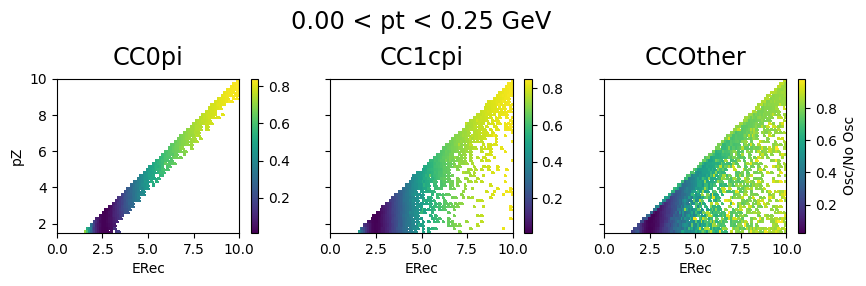

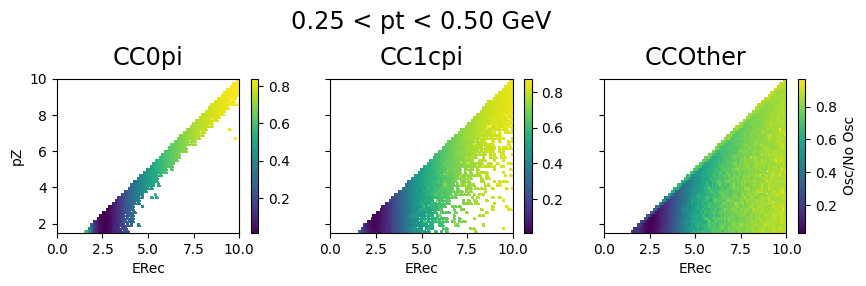

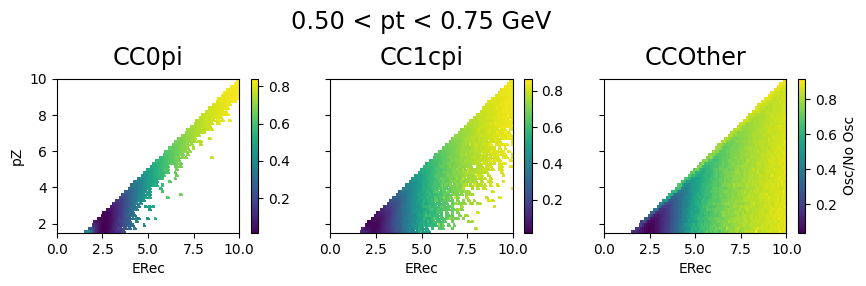

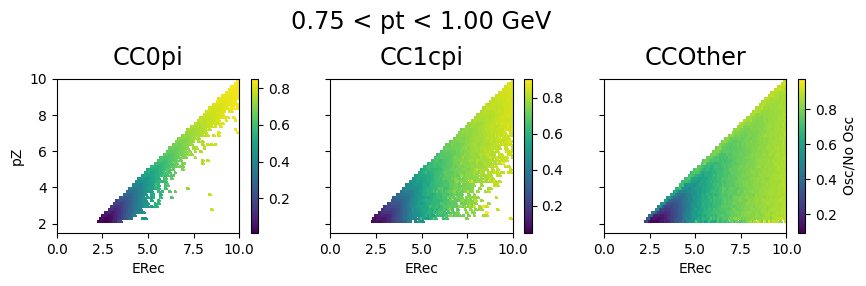

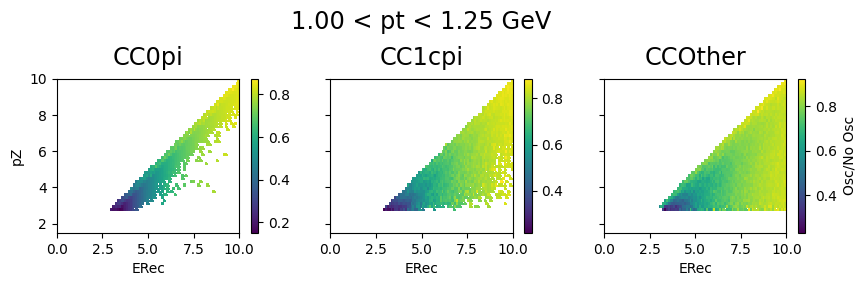

In [14]:
for ptb in ptbins.bins:
    bc = (ptb[0].low + ptb[0].high)/2.0
    pterec = pzpterec_hist.slice(0,bc).project([1,0])
    pterec_osc = pzpterec_hist_osc.slice(0,bc).project([1,0])
    
    fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(10,2),sharey=True)

    pterec_rat = copy.copy(pterec_osc)
    pterec_rat.sumweights = np.divide(pterec_osc.sumweights,pterec.sumweights)

    rat1 = pterec_rat.mpl().colormesh(column="0pi", plot_axis=ax1)
    rat2 = pterec_rat.mpl().colormesh(column="1cpi", plot_axis=ax2)
    rat3 = pterec_rat.mpl().colormesh(column="other", plot_axis=ax3)
    
    ax1.text(5, 10.75,"CC0pi", clip_on=False, 
             horizontalalignment="center", fontsize="xx-large")

    ax2.text(5, 10.75,"CC1cpi", clip_on=False, 
             horizontalalignment="center", fontsize="xx-large")

    ax3.text(5, 10.75,"CCOther", clip_on=False, 
             horizontalalignment="center", fontsize="xx-large")

    ax2.text(5, 12.75,"%.2f < pt < %.2f GeV" % (ptb[0].low,ptb[0].high), clip_on=False, 
             horizontalalignment="center", fontsize="xx-large")

    ax1.set_ylabel("pZ")
    ax1.set_xlabel("ERec")
    ax2.set_xlabel("ERec")
    ax3.set_xlabel("ERec")
    fig.colorbar(rat1)
    fig.colorbar(rat2)
    fig.colorbar(rat3,label="Osc/No Osc")
    fig.show()

In [15]:
import polars as pl
bear = pl.from_arrow(table)

In [17]:
print(bear)

shape: (2_401_614, 13)
┌───────────┬───────────┬───────────┬───────────┬───┬───────────┬───────────┬───────────┬──────────┐
│ event.num ┆ weight.cv ┆ process.i ┆ fatx.esti ┆ … ┆ lep_theta ┆ EAvHad_Ge ┆ ERec_GeV  ┆ prob_dis │
│ ber       ┆ ---       ┆ d         ┆ mate      ┆   ┆ _deg      ┆ V         ┆ ---       ┆ p        │
│ ---       ┆ f64       ┆ ---       ┆ ---       ┆   ┆ ---       ┆ ---       ┆ f32       ┆ ---      │
│ i64       ┆           ┆ i64       ┆ f64       ┆   ┆ f32       ┆ f32       ┆           ┆ f32      │
╞═══════════╪═══════════╪═══════════╪═══════════╪═══╪═══════════╪═══════════╪═══════════╪══════════╡
│ 0         ┆ 1.0       ┆ 600       ┆ 1.3659e-3 ┆ … ┆ 17.457724 ┆ 3.397022  ┆ 5.806564  ┆ 0.963201 │
│           ┆           ┆           ┆ 7         ┆   ┆           ┆           ┆           ┆          │
│ 4         ┆ 1.0       ┆ 600       ┆ 1.3659e-3 ┆ … ┆ 7.758814  ┆ 15.576925 ┆ 26.90217  ┆ 0.976792 │
│           ┆           ┆           ┆ 7         ┆   ┆           ┆   

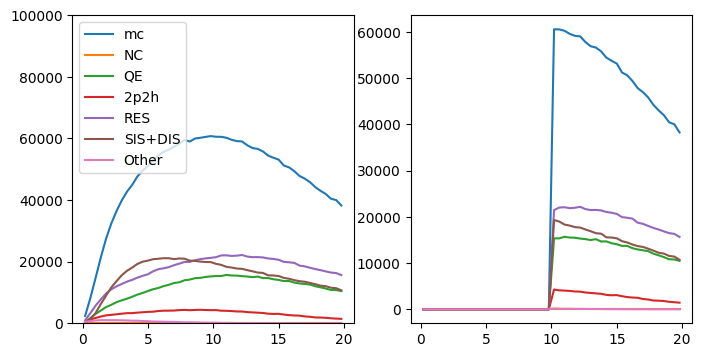

In [34]:
fig, (ax1,ax2) = plt.subplots(1,2, figsize=(8,4))

thetahist = pn.HistFrame(pn.Binning.lin_space(0,20,50))
add_mode_cols(thetahist)

thetahist.fill_columns_from_Arrow(table, ["lep_theta_deg"], "channel_id")
thetahist.mpl().plot_all(plot_axis=ax1)

bear = pl.from_arrow(table)
table_polar_filter = bear.filter(pl.col("lep_theta_deg") > 10).to_arrow()

thetahist.reset()
thetahist.fill_columns_from_Arrow(table_polar_filter, ["lep_theta_deg"], "channel_id")
thetahist.mpl().plot_all(plot_axis=ax2)

ax1.set_ylim([0,100000])
ax1.legend()
fig.show()